<div align = 'center'> Project 1 - Linear Regression and Model Comparison (LBA) 
    
<div align = 'center'> Macbeth K. Matibe
    
<div align = 'center'> Minerva University
    
<div align = 'center'> CS146: Computational Methods for Bayesian Statistics
    
<div align = 'center'> Prof. Volkan
    
<div align = 'center'> October 21, 2023

## Executive Summary

executive summary  goes here

## The Dataset

data source --> https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set 


Real estate valuation data set. (2018). UCI Machine Learning Repository. https://doi.org/10.24432/C5J30W. 

## Loading the Data and importing necessary Libraries

In [1]:
print('Upgrading PyMC to version 5. This takes about 50 seconds...')
!pip install --ignore-installed llvmlite > /dev/null 2> /dev/null
!pip install --upgrade "pymc>=5,<6" numexpr matplotlib numba > /dev/null 2> /dev/null

import pymc as pm
print(f"We're running PyMC v{pm.__version__} today.")

Upgrading PyMC to version 5. This takes about 50 seconds...


WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


We're running PyMC v5.6.1 today.


In [2]:
# Import the necessary libraries
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sts


# Load the data from the CSV file
real_estate = pd.read_csv('Real estate.csv', encoding = "utf-8")
print('This is the Real Estate data')
real_estate = real_estate[real_estate['Y house price of unit area'] <= 100]
real_estate.head()

This is the Real Estate data


,No,X1 transaction date,X2 house age,X3 distance to the nearest MRT station,X4 number of convenience stores,X5 latitude,X6 longitude,Y house price of unit area
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1


## Data Visualization (Scatter Plots of House Price of Unit Area vs Each Independent Variable)

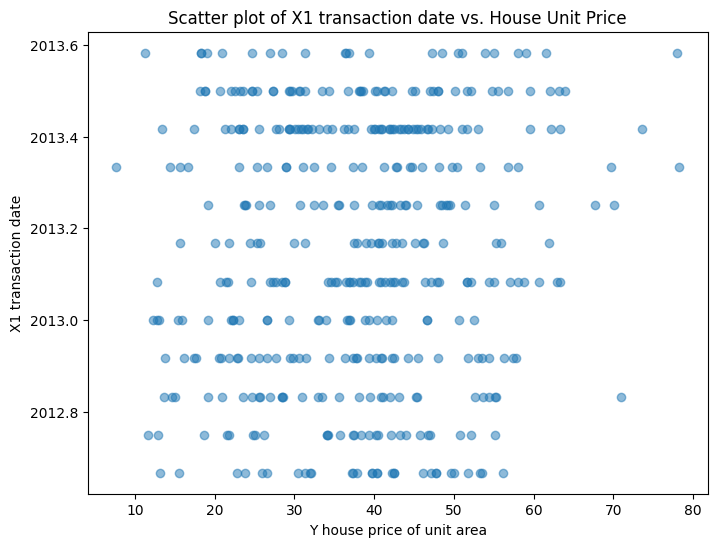

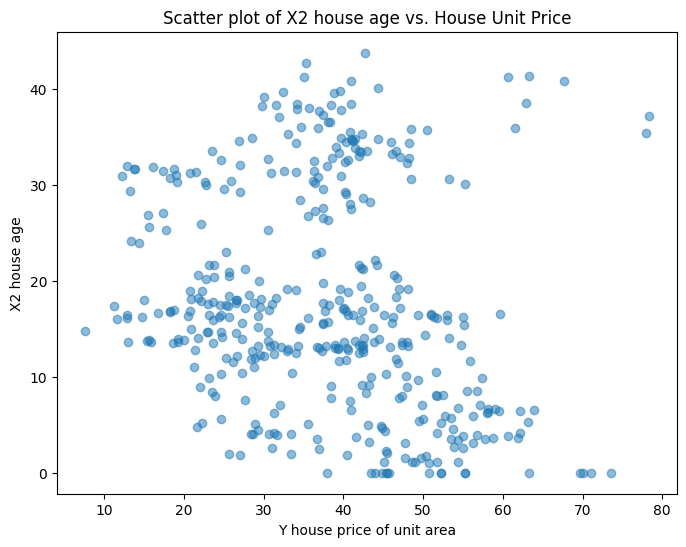

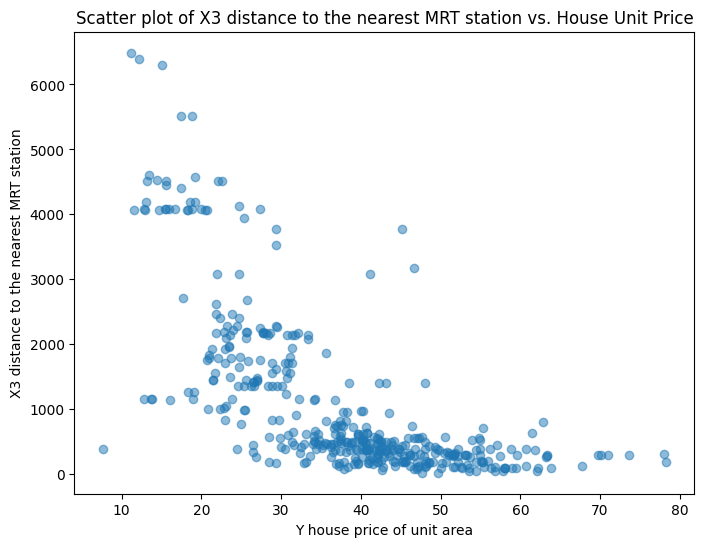

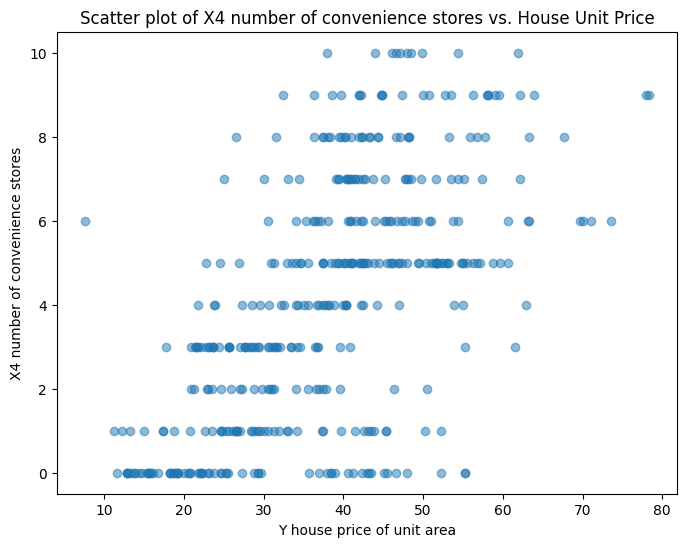

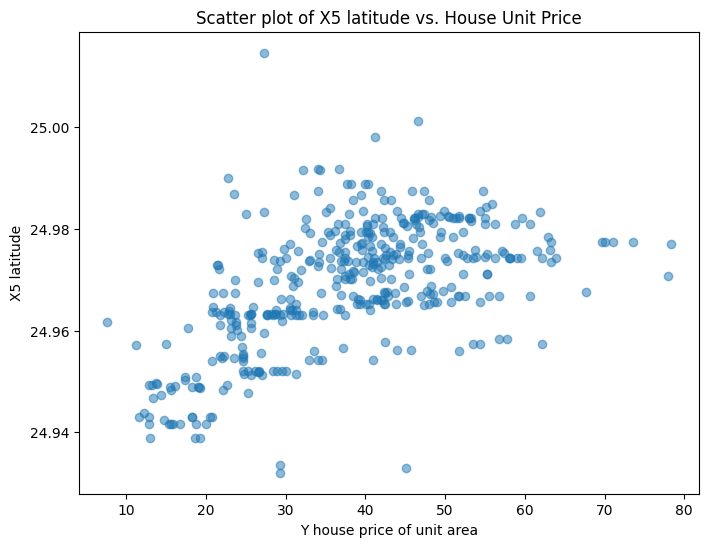

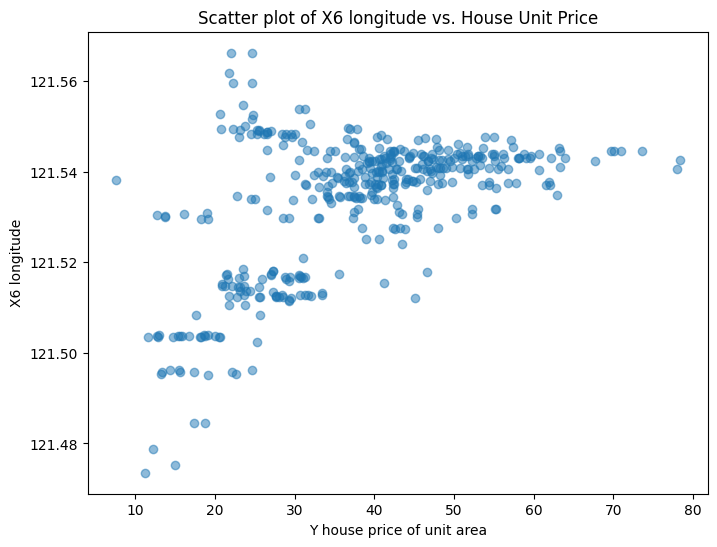

In [3]:
# List of columns to plot against 'house price'
except_col = {'Y house price of unit area', 'No'}
columns_to_plot = [col for col in real_estate.columns if col not in except_col]

for col in columns_to_plot:
    plt.figure(figsize = (8, 6))  
    plt.scatter(real_estate['Y house price of unit area'], real_estate[col], alpha = 0.5)
    plt.title(f'Scatter plot of {col} vs. House Unit Price')
    plt.ylabel(col)
    plt.xlabel('Y house price of unit area')
    plt.show()

### Choice of Independent Variable

## Model 1: 

Discuss Model 1 here

In [4]:
# Linear Model with Normal Likelihood:
with pm.Model() as linear_model:
    # Priors
    a = pm.Normal('a', mu = 0, sigma = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Function
    mu = a + b* real_estate['X3 distance to the nearest MRT station']
    
    # Likelihood 
    unit_price = pm.Normal('unit_price', mu = mu, sigma = sigma, 
                           observed = real_estate['Y house price of unit area'])
    
    # Sampling
    linear_trace = pm.sample(tune = 1000, draws = 1000, chains = 2)
    
# results
az.summary(linear_trace, var_names = ['a', 'b', 'sigma'])


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,45.596,0.628,44.411,46.792,0.020,0.014,999.0,1475.0,1.0
b,-0.007,0.000,-0.008,-0.007,0.000,0.000,954.0,1413.0,1.0
sigma,9.421,0.319,8.832,10.008,0.008,0.006,1526.0,1367.0,1.0


#### Checking the Sampler

interpret rank plots, trace plots and interpret the values of r_hat and ESS, basically the az summary table here

### Visualizing the Model fit (Normal Likelihood)

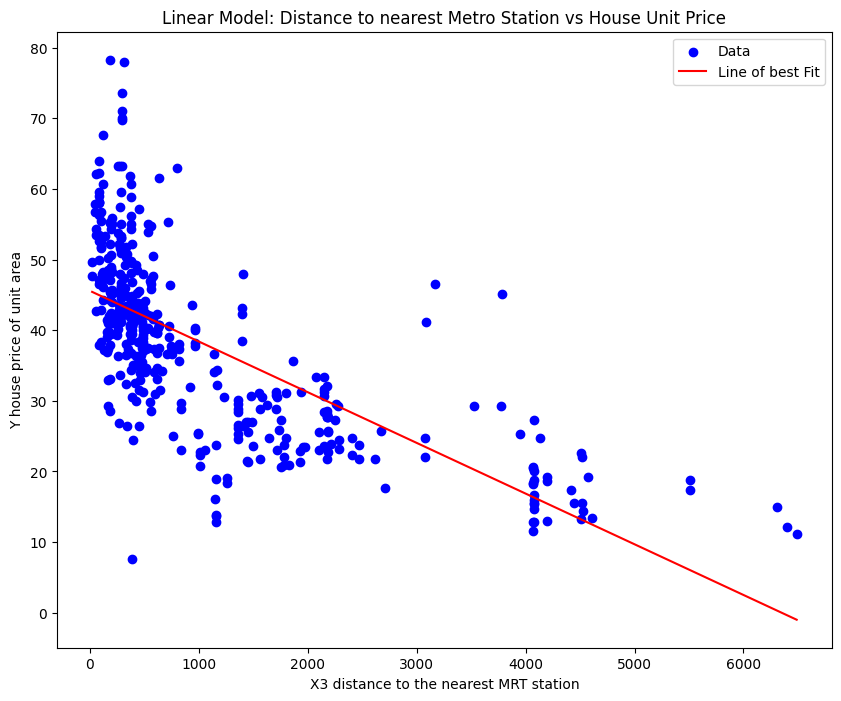

In [5]:
# Compute mean values for alpha and beta
a_samples = linear_trace.posterior["a"].values
b_samples = linear_trace.posterior["b"].values

a_mean = a_samples.mean()
b_mean = b_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 100)
y_vals_linear = a_mean + b_mean * x_vals

# Plot the data with line of best fit
plt.figure(figsize=(10, 8))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], 
            c = 'blue', label = 'Data')
plt.plot(x_vals, y_vals_linear, c = 'red', label = 'Line of best Fit')
plt.title('Linear Model: Distance to nearest Metro Station vs House Unit Price')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

## Model 2: 

Discuss Model 2 here

In [6]:
# Robust Linear Model with Student T likelihood
with pm.Model() as robust_linear_model:
    # Priors
    a = pm.Normal('a', mu = 0, sigma = 100)
    b = pm.Normal('b', mu = 0, sigma = 10)
    nu = pm.Exponential('nu', 1/30) + 1  # degrees of freedom for Student's T
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Function
    mu = a + b * real_estate['X3 distance to the nearest MRT station']
    
    # Likelihood using Student's T
    unit_price = pm.StudentT('unit_price', mu = mu, nu = nu, sigma = sigma, 
                             observed = real_estate['Y house price of unit area'])
    
    # Sampling
    robust_linear_trace = pm.sample(tune = 1000, draws = 1000, chains = 2)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, nu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 35 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


#### Checking the Sampler

interpret rank plots, trace plots and interpret the values of r_hat and ESS, basically the az summary table here

### Visualizing the Model fit (Student T Likelihood)

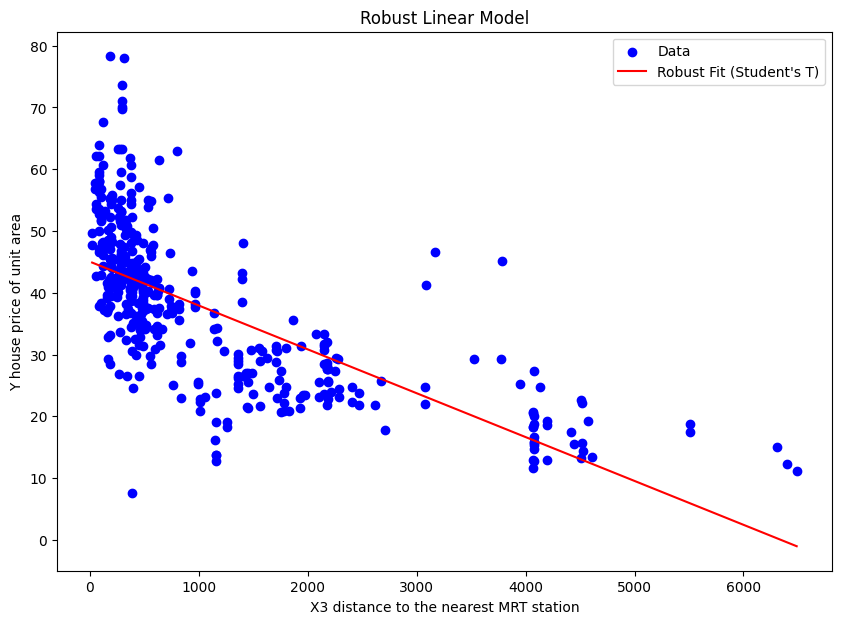

In [7]:
# Compute mean values for alpha and beta
a2_samples = robust_linear_trace.posterior['a'].values
b2_samples = robust_linear_trace.posterior['b'].values

a2_mean = a2_samples.mean()
b2_mean = b2_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals2 = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 100)
y_vals_robust = a2_mean + b2_mean * x_vals2

# Plot the data with the line of best fit
plt.figure(figsize=(10, 7))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], 
            c='blue', label='Data')
plt.plot(x_vals, y_vals_robust, c='red', label='Robust Fit (Student\'s T)')
plt.title('Robust Linear Model')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

interpret the resulsts here or say smth about the model

In [8]:
# Quadratic model
with pm.Model() as quadratic_model:
    # Priors
    a = pm.Normal('a', mu=0, sigma=100)
    b1 = pm.Normal('b1', mu=0, sigma=10)
    b2 = pm.Normal('b2', mu=0, sigma=10)
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Deterministic function
    mu = a + b1 * real_estate['X3 distance to the nearest MRT station'] + b2 * real_estate['X3 distance to the nearest MRT station']**2
    
    # Likelihood
    unit_price = pm.Normal('unit_price', mu = mu, sigma = sigma, 
                        observed = real_estate['Y house price of unit area'])
    
    # Sampling
    trace_quadratic = pm.sample(tune = 1000, draws = 1000, chains = 2)

# Results
print(az.summary(trace_quadratic, var_names=['a', 'b1', 'b2', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b1, b2, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 93 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      49.391  0.763  47.949   50.824      0.037    0.026     431.0     551.0   
b1     -0.015  0.001  -0.017   -0.013      0.000    0.000     389.0     654.0   
b2      0.000  0.000   0.000    0.000      0.000    0.000     519.0     841.0   
sigma   8.708  0.301   8.150    9.271      0.010    0.007     855.0     913.0   

       r_hat  
a       1.01  
b1      1.01  
b2      1.00  
sigma   1.00  


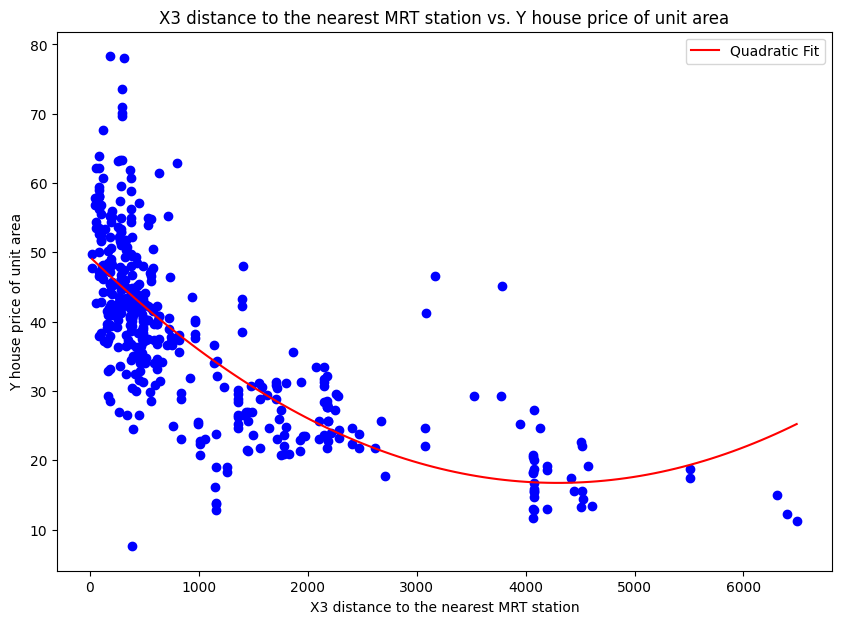

In [9]:
a_samples_q = trace_quadratic.posterior["a"].values
b1_samples = trace_quadratic.posterior["b1"].values
b2_samples = trace_quadratic.posterior["b2"].values

a_mean_q = a_samples_q.mean()
b1_mean = b1_samples.mean()
b2_mean = b2_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 100)
y_vals_quadratic = a_mean_q + b1_mean * x_vals + b2_mean * x_vals**2

# Plot the data with lines of best fit
plt.figure(figsize=(10, 7))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], c = 'blue')
plt.plot(x_vals, y_vals_quadratic, c='red', label='Quadratic Fit')
plt.title('X3 distance to the nearest MRT station vs. Y house price of unit area')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()


In [10]:
# Robust Quadratic Model using Student's T distribution
with pm.Model() as robust_quadratic_model:
    # Priors
    a = pm.Normal('a', mu=0, sigma=100)
    b = pm.Normal('b', mu=0, sigma=10)
    c = pm.Normal('c', mu=0, sigma=10)  # quadratic term coefficient
    nu = pm.Exponential('nu', 1/30) + 1  # degrees of freedom for Student's T
    sigma = pm.Uniform('sigma', 0, 30)
    
    # Quadratic function
    mu = a + b * real_estate['X3 distance to the nearest MRT station'] + c * real_estate['X3 distance to the nearest MRT station']**2
    
    # Robust likelihood using Student's T distribution
    unit_price = pm.StudentT('unit_price', mu=mu, nu=nu, sigma=sigma, observed=real_estate['Y house price of unit area'])
    
    # Sampling
    robust_quadratic_trace = pm.sample(tune=1000, draws=1000, chains=2)


# Results
print(az.summary(robust_quadratic_trace, var_names=['a', 'b', 'c', 'nu', 'sigma']))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [a, b, c, nu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 124 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a      48.751  0.665  47.574   50.102      0.026    0.018     671.0    1020.0   
b      -0.015  0.001  -0.017   -0.013      0.000    0.000     663.0     988.0   
c       0.000  0.000   0.000    0.000      0.000    0.000     738.0     924.0   
nu      3.571  1.234   1.661    5.894      0.045    0.032     742.0    1023.0   
sigma   6.555  0.444   5.746    7.387      0.016    0.012     738.0     979.0   

       r_hat  
a        1.0  
b        1.0  
c        1.0  
nu       1.0  
sigma    1.0  


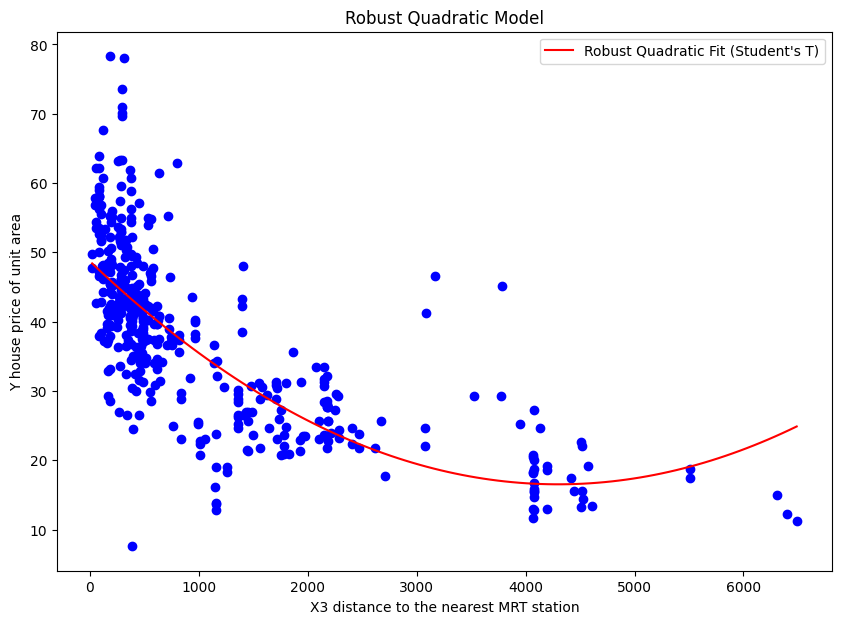

In [11]:
# Compute mean values for the parameters
a3_samples = robust_quadratic_trace.posterior['a'].values
b3_samples = robust_quadratic_trace.posterior['b'].values
c3_samples = robust_quadratic_trace.posterior['c'].values

a3_mean = a3_samples.mean()
b3_mean = b3_samples.mean()
c3_mean = c3_samples.mean()

# Generate predicted values using the mean parameter estimates
x_vals = np.linspace(min(real_estate['X3 distance to the nearest MRT station']), 
                     max(real_estate['X3 distance to the nearest MRT station']), 100)
y_vals_robust_quadratic = a3_mean + b3_mean * x_vals + c3_mean * x_vals**2

# Plot the data with the line of best fit
plt.figure(figsize=(10, 7))
plt.scatter(real_estate['X3 distance to the nearest MRT station'], 
            real_estate['Y house price of unit area'], c = 'blue')
plt.plot(x_vals, y_vals_robust_quadratic, c='red', label='Robust Quadratic Fit (Student\'s T)')
plt.title('Robust Quadratic Model')
plt.xlabel('X3 distance to the nearest MRT station')
plt.ylabel('Y house price of unit area')
plt.legend()
plt.show()

## Model 3: Outlier Detection Likelihood 

Discuss model 3 here

## Comparison of the 3 Models: PSIS leave-one-out cross-validation

Discuss what you are going to do to compare the three models

/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/macbethmatibe/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


WAIC for Linear Model: Computed from 2000 posterior samples and 413 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  3027.83    37.02
p_waic            3.52        -
WAIC for Robust Linear Model: Computed from 2000 posterior samples and 413 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  3012.32    36.14
p_waic            4.24        -
WAIC for Quadratic Model: Computed from 2000 posterior samples and 413 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  2965.34    41.02
p_waic            5.10        -

There has been a warning during the calculation. Please check the results.
WAIC for Robust Quadratic Model: Computed from 2000 posterior samples and 413 observations log-likelihood matrix.

              Estimate       SE
deviance_waic  2930.24    39.04
p_waic            5.17        -

There has been a warning during the calculation. Please check the results.
                  rank  

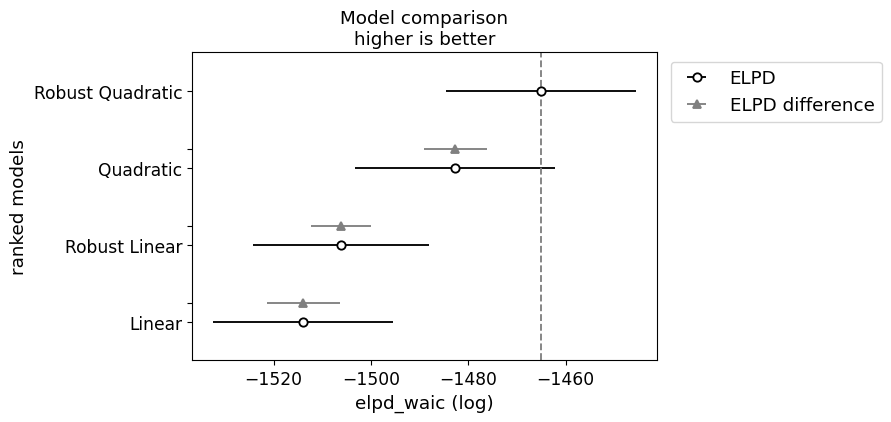

In [12]:
# Compute log likelihood and WAIC for Linear Model
with linear_model:
    pm.compute_log_likelihood(linear_trace)
waic_linear = az.waic(linear_trace, scale='deviance')

# Compute log likelihood and WAIC for Robust Linear Model
with robust_linear_model:
    pm.compute_log_likelihood(robust_linear_trace)
waic_robust_linear = az.waic(robust_linear_trace, scale='deviance')

# Compute log likelihood and WAIC for Quadratic Model
with quadratic_model:
    pm.compute_log_likelihood(trace_quadratic)
waic_quadratic = az.waic(trace_quadratic, scale='deviance')

# Compute log likelihood and WAIC for Robust Quadratic Model
with robust_quadratic_model:
    pm.compute_log_likelihood(robust_quadratic_trace)
waic_robust_quadratic = az.waic(robust_quadratic_trace, scale='deviance')

# Print WAIC for each model
print("WAIC for Linear Model:", waic_linear)
print("WAIC for Robust Linear Model:", waic_robust_linear)
print("WAIC for Quadratic Model:", waic_quadratic)
print("WAIC for Robust Quadratic Model:", waic_robust_quadratic)

# Compare the models using arviz.compare
comparison = az.compare({
    'Linear': linear_trace,
    'Robust Linear': robust_linear_trace,
    'Quadratic': trace_quadratic,
    'Robust Quadratic': robust_quadratic_trace
}, ic='waic')

print(comparison)

# Visualizing the comparison
az.plot_compare(comparison)
plt.show()


## References

references go here

#### AI Policy Statement

Your Statement Goes Here